# Augmentation comparison

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random
import pandas as pd
from tqdm import tqdm
import scipy.stats as stats

In [3]:
models_folder_path = 'classifiers/official'
model_names = os.listdir(models_folder_path)
models_to_compare = []
for model in model_names:
    if os.path.exists(os.path.join(models_folder_path, model, "classification_report.json")):
        models_to_compare.append(model)


In [4]:
DATASET_NAME = "NEW_DATASET_1"
audio_path = f"E:/Giacomo/Tovanella/{DATASET_NAME}/test"
all_species = os.listdir(audio_path)

## Classification report comparisons

In [5]:
results_folders = "classifiers\official"
class_reports = {}
for model_name in models_to_compare:
    with open(os.path.join(results_folders, model_name, "classification_report.json"), "r") as f:
        class_reports[model_name] = json.load(f)

In [6]:
results = []

for model_name, report in class_reports.items():
    df = pd.DataFrame(report).T
    # remove species not in augmented_species
    weighted_precision = (df["precision"] * df["support"]).sum() / df["support"].sum()
    weighted_recall = (df["recall"] * df["support"]).sum() / df["support"].sum()
    weighted_f1 = (df["f1-score"] * df["support"]).sum() / df["support"].sum()

    results.append({
        "Model Name": model_name,
        "Precision": round(weighted_precision, 4),
        "Recall": round(weighted_recall, 4),
        "F1-score": round(weighted_f1, 4),
    })

# Creare tabella finale
df_summary = pd.DataFrame(results)
df_summary.sort_values("F1-score", ascending=False)

,Model Name,Precision,Recall,F1-score
1,ludovica,0.7050,0.1760,0.2608
2,pasqualo,0.0589,0.0397,0.0345
0,angelo,0.0677,0.0147,0.0080
3,rebecca,0.0270,0.0144,0.0078


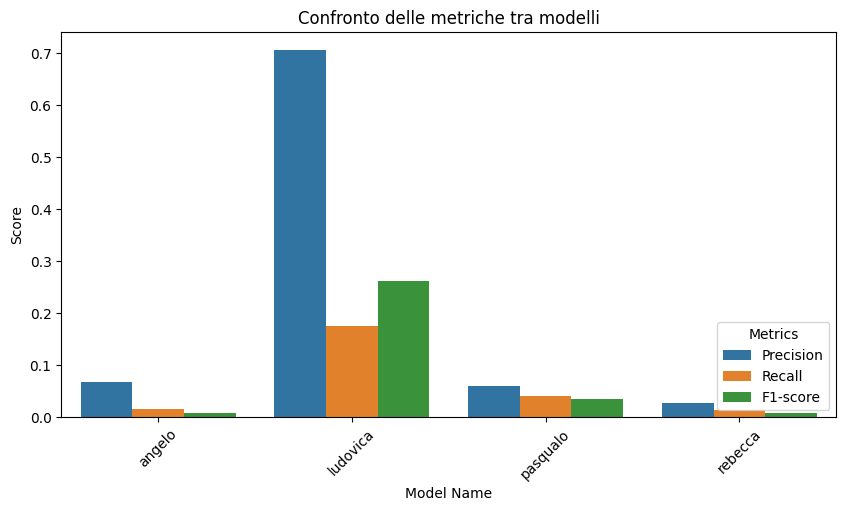

In [7]:
plt.figure(figsize=(10, 5))
df_melted = df_summary.melt(id_vars=["Model Name"], value_vars=["Precision", "Recall", "F1-score"])
sns.barplot(x="Model Name", y="value", hue="variable", data=df_melted)

plt.title("Confronto delle metriche tra modelli")
plt.ylabel("Score")
plt.xlabel("Model Name")
plt.xticks(rotation=45)
plt.legend(title="Metrics", loc="lower right")
plt.show()

## ROC AUC comparisons

In [ ]:
# roc_curves = {}
# for model_name in models_to_compare:
#     if os.path.exists(os.path.join(results_folders, model_name, "roc_auc.json")):
#         with open(os.path.join(results_folders, model_name, "roc_auc.json"), "r") as f:
#             roc_curves[model_name] = json.load(f)

In [ ]:
# roc_results = []
# for model_name, roc_data in roc_curves.items():
#     auc_values = [specie_data["auc"] for specie_name, specie_data in roc_data.items() if specie_name in all_species]
#     mean_auc = sum(auc_values) / len(auc_values)
#     roc_results.append({
#         "Model Name": model_name,
#         "Mean AUC": round(mean_auc, 4),
#         "Species Count": len(auc_values)  # Numero di specie nel dataset
#     })

# # Creare DataFrame e salvare
# df_auc = pd.DataFrame(roc_results)
# df_auc.sort_values("Mean AUC", ascending=False)

KeyError: 'Mean AUC'

## t-test on different models

In [10]:
experiments = {}
for model in models_to_compare:
    experiments[model] = {}
    # experiments[model]["roc"] = roc_curves[model]
    experiments[model]["class_report"] = class_reports[model]

In [11]:
# for each model, associate an array of f1 scores for each specie
model_f1_scores = {}
for model in models_to_compare:
    f1_scores = []
    for specie in all_species:
        f1_scores.append(class_reports[model][specie]["f1-score"])
    model_f1_scores[model] = f1_scores

In [12]:
# check normality, if p-value < 0.05 then the distribution is not normal
from scipy.stats import shapiro

for model, scores in model_f1_scores.items():
    stat, p = shapiro(scores)
    print(f"{model}: p-value = {p}")

angelo: p-value = 1.7108358463246987e-07
ludovica: p-value = 0.7523309588432312
pasqualo: p-value = 4.14324375697106e-07
rebecca: p-value = 1.0097657110463842e-07


In [ ]:
import numpy as np
from scipy.stats import wilcoxon

wilcoxon_results = []
base_model_name = "rebecca"
for model_name in models_to_compare:
    if model_name == base_model_name:
        continue
    
    f1_model_A = model_f1_scores[base_model_name]
    f1_model_B = model_f1_scores[model_name]
    t_stat, p_value = wilcoxon(f1_model_A, f1_model_B)

    # Salva i risultati
    wilcoxon_results.append({
        "Model Name": model_name,
        "t-statistic": round(t_stat, 4),
        "p-value": round(p_value, 4),
        "Significativo?": "Sì" if p_value < 0.05 else "No"
    })

# Crea DataFrame e salva
df_ttest = pd.DataFrame(wilcoxon_results)
df_ttest.sort_values("p-value")

KeyError: 'original'

In [ ]:
t_test_results = []
for model_name in models_to_compare:
    if model_name == base_model_name:
        continue
    
    base_model = model_f1_scores[base_model_name]
    other_model = model_f1_scores[model_name]
    t_stat, p_value = stats.ttest_ind(base_model, other_model, equal_var=False)

    # Salva i risultati
    t_test_results.append({
        "Model Name": model_name,
        "t-statistic": round(t_stat, 4),
        "p-value": round(p_value, 4),
        "Significativo?": "Sì" if p_value < 0.05 else "No"
    })

# Crea DataFrame e salva
df_ttest = pd.DataFrame(t_test_results)
df_ttest.sort_values("p-value")

,Model Name,t-statistic,p-value,Significativo?
0,wabad_on_minor,-1.2990,0.2023,No
2,wabad_augm_ps,-1.2673,0.2133,No
6,carmela,-1.2136,0.2329,No
1,wabad_all,-0.3734,0.7111,No
3,original_200_best_snr,0.3666,0.7161,No
5,maurizio_complesso,-0.1162,0.9082,No
4,maurizio,-0.1006,0.9204,No


In [ ]:
from scipy.stats import bootstrap

n_resamples = 10000  

# Bootstrap con metodo BCA (bias-corrected and accelerated)
ci = bootstrap((model_f1_scores["pasqualo"],), np.mean, confidence_level=0.95, n_resamples=n_resamples, method='BCa')

# Output intervallo di confidenza
print(f"Intervallo di confidenza 95% per F1-score: {ci.confidence_interval}")

Intervallo di confidenza 95% per F1-score: ConfidenceInterval(low=0.2579832692114786, high=0.4647412491416596)
